# Convert image classification data to TFRecords

## Overview
This colab will demonstrate how to use the data converter tool to easily convert raw image data into TFRecords consumable by TPU models.

The goal of this colab is to illustrate a few possible use cases through demonstrated scenarios to get an understanding of the steps required to run the conversion.


First import the necessary packages:

In [0]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import pprint

from PIL import Image, ImageOps

import glob
import io
import os
import yaml

%matplotlib inline

In [0]:
! git clone -b image_classification_converter https://github.com/tensorflow/tpu.git 

Cloning into 'tpu'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 7492 (delta 12), reused 14 (delta 7), pack-reused 7457
Receiving objects: 100% (7492/7492), 22.21 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (5265/5265), done.


In [0]:
% cd tpu/tools/data_converter

/content/tpu/tools/data_converter


In [0]:
from image_classification.image_classification_data import ImageClassificationBuilder
from image_classification.image_classification_data import ImageClassificationConfig

Before we get into the data conversion portion, let's first provide a way to generate raw example images:

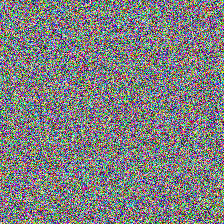

In [0]:
def generate_raw_image(shape=(224, 224, 3)):
  im_array = np.random.random(shape)
  return Image.fromarray(np.uint8(im_array * 255))

generate_raw_image()

Let's also provide a way to view the structure of a directory:

In [0]:
def print_folder_directory(root_path):
  for root, dirs, files in os.walk(root_path):
    level = root.replace(root_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print ('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
      print ('{}-{}'.format(subindent, f))

## How does the data converter work?
The main idea of the converter is that providing a mapping between relevant files is enough to carry out the conversion without needing to write additional code. This is done by writing a generator that generates tuples of the relevant data fields. For image classification, this generator would provide tuples of image files and labels.

The converter builds on top of [TensorFlow Datasets](https://www.tensorflow.org/datasets). The converter itself is an implementation of a [DatasetBuilder](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder) and relies on a provided [BuilderConfig](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/BuilderConfig.md) implementation to run data conversions.

For the image classification scenario, the configuration requires a few fields:


*   `num_labels` - the number of labels in the dataset.
*   `supported_modes` - the list of supported modes in the dataset.
*   `example_generator` - a generator that returns the set of image examples for a given 'mode'.


Once a configuration is implemented and provided to the converter, the tool will convert the data into TFRecords that can be used with TPU models, e.g. image classification models within https://github.com/tensorflow/tpu/tree/master/models/official.

The following scenarios will illustrate exactly how this should be used:



## Scenario 1:
Consider the scenario in which you have images in a directory layout similar to the following:

    root
    |
    --train
        |
        --class-1
            |
            --image_0.jpg
            |
            --image_1.jpg
            |
            ...
        --class-2
            |
            ...
    --validation
        |
        --class-1
        ...

e.g. the top level directories include the modes (train, validation), the subdirectory below that includes the class labels, and within each directory are example images.

Let's generate a dataset that follows this format. For demonstration purposes, we will use the modes 'train' and 'validation' and contain only 5 classes with 5 images per class.

In [0]:
def generate_dataset_scenario1(root_path,
                               modes=('train', 'validation'),
                               num_classes=5,
                               num_images_per_class=5):
  for mode in modes:
    mode_path = os.path.join(root_path, mode)
    os.makedirs(mode_path, exist_ok=True)
    for class_index in range(num_classes):
      class_name = 'class-{}'.format(class_index)
      class_dir = os.path.join(mode_path, class_name)
      os.makedirs(class_dir, exist_ok=True)
      for image_index in range(num_images_per_class):
        image_path = os.path.join(class_dir, 'image-{}.jpg'.format(image_index))
        image = generate_raw_image()
        image.save(image_path)

root_path = tempfile.mkdtemp()
generate_dataset_scenario1(root_path)
print_folder_directory(root_path)

tmprzbbh2j9/
    train/
        class-2/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
        class-4/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
        class-1/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
        class-3/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
        class-0/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
    validation/
        class-2/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -image-2.jpg
            -image-4.jpg
        class-4/
            -image-0.jpg
            -image-3.jpg
            -image-1.jpg
            -ima

Now that we know the heuristic used in the dataset, let's create the ImageClassificationConfig that reflects this:

In [0]:
class Scenario1Config(ImageClassificationConfig):
  def __init__(self, root_path, *args, **kwargs):
    super(Scenario1Config, self).__init__(
      version=tfds.core.Version('0.1.0'),
      supported_versions=[],
      **kwargs)
    self.root_path = root_path

  @property
  def supported_modes(self):
    return ('train', 'validation')

  @property
  def num_labels(self):
    return 5

  def example_generator(self, mode):
    data_path = self.root_path
    mode_path = os.path.join(data_path, mode)

    for class_name in os.listdir(mode_path):
      class_dir = os.path.join(mode_path, class_name)
      for img_path in os.listdir(class_dir):
        abs_path = os.path.abspath(os.path.join(class_dir, img_path))
        yield {
            'image_fobj': tf.io.gfile.GFile(abs_path, 'rb'),
            'label': class_name,
        }

Next, let's supply this to the tool and run the conversion. Note that:


*   a `name` must be provided to the Config as shown below
*   the `data_dir` provided is used by TFDS to save converted TFRecords.




In [0]:
config = Scenario1Config(name='Scenario 1 configuration',
                         description='Toy example for scenario 1',
                         root_path=root_path)
tfrecord_root = tempfile.mkdtemp()
ds = ImageClassificationBuilder(data_dir=tfrecord_root,
                                config=config)
ds.download_and_prepare()

Shuffling and writing examples to /tmp/tmpptanxorz/image_classification_builder/Scenario 1 configuration/0.1.0.incomplete4A6PWE/image_classification_builder-train.tfrecord


Shuffling and writing examples to /tmp/tmpptanxorz/image_classification_builder/Scenario 1 configuration/0.1.0.incomplete4A6PWE/image_classification_builder-validation.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset image_classification_builder downloaded and prepared to /tmp/tmpptanxorz/image_classification_builder/Scenario 1 configuration/0.1.0. Subsequent calls will reuse this data.


In [0]:
print_folder_directory(tfrecord_root)

tmpptanxorz/
    downloads/
        extracted/
    image_classification_builder/
        Scenario 1 configuration/
            0.1.0/
                -image-encoded.image.json
                -dataset_info.json
                -image_classification_builder-train.tfrecord-00000-of-00001
                -image_classification_builder-validation.tfrecord-00000-of-00001


We can see that the data has been successfully converted into TFRecords. Let's take a look at some of the examples to verify:

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


features {
  feature {
    key: "image/channels"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "image/class/text"
    value {
      bytes_list {
        value: "class-1"
      }
    }
  }
  feature {
    key: "image/colorspace"
    value {
      bytes_list {
        value: "RGB"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

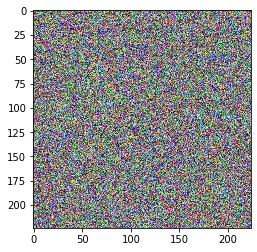

In [0]:
def show_image_from_bytes(binary_image):
  im = Image.open(io.BytesIO(binary_image)).convert("RGB")
  plt.imshow(im)

def visualize_tfrecord(tf_record_path):
  example = next(tf.python_io.tf_record_iterator(tf_record_path))
  tf_example = tf.train.Example.FromString(example)
  print (tf_example)
  show_image_from_bytes(tf_example.features.feature['image/encoded'].bytes_list.value[0])
  
tf_record_path = os.path.join(
    tfrecord_root,
    'image_classification_builder',
    'Scenario 1 configuration',
    '0.1.0',
    'image_classification_builder-train.tfrecord-00000-of-00001')
visualize_tfrecord(tf_record_path)

## Scenario 2
Imagine that your data collection pipeline simply stores all of the images in one central directory and maintains some sort of mapping file (e.g. a YAML file) between the mode, image files and the class labels. For example:

```
files: image0.jpg, image1.jpg, image2.jpg, ...
mapping: {
  'train': {
    'class1': [image0.jpg, image1.jpg, ...]
    'class2': [image10.jpg, image11.jpg, ...]
    ...
  }
  'validation': {
    'class1': [image100.jpg, image101.jpg, ...]
    ...
  }
  ...
}
```


Let's see how this might work:

In [0]:
def generate_dataset_scenario2(root_path,
                               modes=('train', 'validation'),
                               num_classes=5,
                               num_images_per_class=5):
  os.makedirs(root_path, exist_ok=True)
  mapping = {}

  for mode in modes:
    mapping[mode] = {}
    for class_index in range(num_classes):
      class_name = 'class-{}'.format(class_index)
      mapping[mode][class_name] = []
      for image_index in range(num_images_per_class):
        num_images = num_images_per_class * class_index + image_index
        img_path = os.path.join(root_path, 'im-{}.jpg'.format(num_images))
        mapping[mode][class_name].append(img_path)
        image = generate_raw_image()
        image.save(img_path)
  with open(os.path.join(root_path, 'mapping.yaml'), 'w') as fp:
    yaml.dump(mapping, fp)
  print ("Mapping: ")
  pp = pprint.PrettyPrinter()
  print (pp.pformat(mapping))


root_path = tempfile.mkdtemp()
generate_dataset_scenario2(root_path)
print_folder_directory(root_path)

Mapping: 
{'train': {'class-0': ['/tmp/tmp96pqonw3/im-0.jpg',
                       '/tmp/tmp96pqonw3/im-1.jpg',
                       '/tmp/tmp96pqonw3/im-2.jpg',
                       '/tmp/tmp96pqonw3/im-3.jpg',
                       '/tmp/tmp96pqonw3/im-4.jpg'],
           'class-1': ['/tmp/tmp96pqonw3/im-5.jpg',
                       '/tmp/tmp96pqonw3/im-6.jpg',
                       '/tmp/tmp96pqonw3/im-7.jpg',
                       '/tmp/tmp96pqonw3/im-8.jpg',
                       '/tmp/tmp96pqonw3/im-9.jpg'],
           'class-2': ['/tmp/tmp96pqonw3/im-10.jpg',
                       '/tmp/tmp96pqonw3/im-11.jpg',
                       '/tmp/tmp96pqonw3/im-12.jpg',
                       '/tmp/tmp96pqonw3/im-13.jpg',
                       '/tmp/tmp96pqonw3/im-14.jpg'],
           'class-3': ['/tmp/tmp96pqonw3/im-15.jpg',
                       '/tmp/tmp96pqonw3/im-16.jpg',
                       '/tmp/tmp96pqonw3/im-17.jpg',
                       '/tmp/tmp96pqonw3/im

The configuration can then be provided the YAML file and use it to fill the generator:

In [0]:
class Scenario2Config(ImageClassificationConfig):
  def __init__(self, yaml_file, *args, **kwargs):
    super(Scenario2Config, self).__init__(
      version=tfds.core.Version('0.1.0'),
      supported_versions=[],
      **kwargs)
    self.mapping = yaml.load(open(yaml_file, 'rb'))

  @property
  def supported_modes(self):
    return ('train', 'validation')

  @property
  def num_labels(self):
    return 5

  def example_generator(self, mode):
    class_mapping = self.mapping[mode]

    for class_name, file_list in class_mapping.items():
      for image_file in file_list:
        yield {
            'image_fobj': tf.io.gfile.GFile(image_file, 'rb'),
            'label': class_name,
        }

In [0]:
config = Scenario2Config(name='Scenario 2 configuration',
                         description='Toy example for scenario 2',
                         yaml_file=os.path.join(root_path, 'mapping.yaml'))
tfrecord_root = tempfile.mkdtemp()
ds = ImageClassificationBuilder(data_dir=tfrecord_root,
                                config=config)
ds.download_and_prepare()

Shuffling and writing examples to /tmp/tmpufgnm7ee/image_classification_builder/Scenario 2 configuration/0.1.0.incomplete11C1ZA/image_classification_builder-train.tfrecord


Shuffling and writing examples to /tmp/tmpufgnm7ee/image_classification_builder/Scenario 2 configuration/0.1.0.incomplete11C1ZA/image_classification_builder-validation.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset image_classification_builder downloaded and prepared to /tmp/tmpufgnm7ee/image_classification_builder/Scenario 2 configuration/0.1.0. Subsequent calls will reuse this data.


features {
  feature {
    key: "image/channels"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "image/class/text"
    value {
      bytes_list {
        value: "class-0"
      }
    }
  }
  feature {
    key: "image/colorspace"
    value {
      bytes_list {
        value: "RGB"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

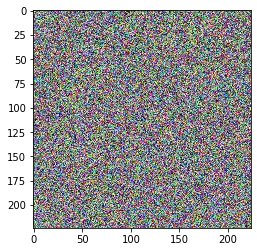

In [0]:
tf_record_path = os.path.join(
    tfrecord_root,
    'image_classification_builder',
    'Scenario 2 configuration',
    '0.1.0',
    'image_classification_builder-train.tfrecord-00000-of-00001')
visualize_tfrecord(tf_record_path)

## Scenario 3
Let's consider a scenario in which all files are saved in a directory with the naming convention:

`mode-class-image.jpg`

In [0]:
def generate_dataset_scenario3(root_path,
                               modes=('train', 'validation'),
                               num_classes=5,
                               num_images_per_class=5):
  os.makedirs(root_path, exist_ok=True)

  for mode in modes:
    for class_index in range(num_classes):
      class_name = 'class_{}'.format(class_index)
      for image_index in range(num_images_per_class):
        image_path = os.path.join(root_path, '{}-{}-{}.jpeg'.format(
            mode,
            class_name,
            'image-{}'.format(image_index)
        ))
        image = generate_raw_image()
        image.save(image_path)


root_path = tempfile.mkdtemp()
generate_dataset_scenario3(root_path)
print_folder_directory(root_path)

tmpehl8zspc/
    -train-class_0-image-3.jpeg
    -validation-class_4-image-3.jpeg
    -train-class_2-image-2.jpeg
    -train-class_4-image-3.jpeg
    -train-class_4-image-1.jpeg
    -train-class_3-image-0.jpeg
    -validation-class_0-image-0.jpeg
    -train-class_4-image-2.jpeg
    -validation-class_0-image-4.jpeg
    -train-class_0-image-2.jpeg
    -validation-class_3-image-4.jpeg
    -train-class_4-image-0.jpeg
    -train-class_3-image-4.jpeg
    -train-class_3-image-1.jpeg
    -train-class_0-image-0.jpeg
    -validation-class_1-image-2.jpeg
    -train-class_2-image-0.jpeg
    -train-class_0-image-1.jpeg
    -train-class_1-image-1.jpeg
    -train-class_4-image-4.jpeg
    -validation-class_4-image-0.jpeg
    -validation-class_0-image-2.jpeg
    -validation-class_2-image-2.jpeg
    -validation-class_3-image-0.jpeg
    -validation-class_2-image-4.jpeg
    -validation-class_2-image-0.jpeg
    -train-class_2-image-4.jpeg
    -train-class_1-image-3.jpeg
    -train-class_0-image-4.jpeg
    

The configuration can fill the generator given the root directory:

In [0]:
class Scenario3Config(ImageClassificationConfig):
  def __init__(self, root_path, *args, **kwargs):
    super(Scenario3Config, self).__init__(
      version=tfds.core.Version('0.1.0'),
      supported_versions=[],
      **kwargs)
    self.root_path = root_path

  @property
  def supported_modes(self):
    return ('train', 'validation')

  @property
  def num_labels(self):
    return 5

  def example_generator(self, mode):
    mode_files = glob.glob(os.path.join(self.root_path, '{}**'.format(mode)))
    for image_file in mode_files:
      class_name = os.path.basename(image_file).split('-')[1]
      yield {
          'image_fobj': tf.io.gfile.GFile(image_file, 'rb'),
          'label': class_name
      }

In [0]:
config = Scenario3Config(name='Scenario 3 configuration',
                         description='Toy example for scenario 3',
                         root_path=root_path)
tfrecord_root = tempfile.mkdtemp()
ds = ImageClassificationBuilder(data_dir=tfrecord_root,
                                config=config)
ds.download_and_prepare()

Shuffling and writing examples to /tmp/tmpaonbege6/image_classification_builder/Scenario 3 configuration/0.1.0.incompleteTJBLFG/image_classification_builder-train.tfrecord


Shuffling and writing examples to /tmp/tmpaonbege6/image_classification_builder/Scenario 3 configuration/0.1.0.incompleteTJBLFG/image_classification_builder-validation.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset image_classification_builder downloaded and prepared to /tmp/tmpaonbege6/image_classification_builder/Scenario 3 configuration/0.1.0. Subsequent calls will reuse this data.


features {
  feature {
    key: "image/channels"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "image/class/text"
    value {
      bytes_list {
        value: "class_4"
      }
    }
  }
  feature {
    key: "image/colorspace"
    value {
      bytes_list {
        value: "RGB"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

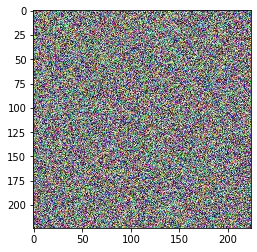

In [0]:
tf_record_path = os.path.join(
    tfrecord_root,
    'image_classification_builder',
    'Scenario 3 configuration',
    '0.1.0',
    'image_classification_builder-train.tfrecord-00000-of-00001')
visualize_tfrecord(tf_record_path)